# purpose of this notebook

The purpose of this notebook will be to make some example plots tracking Atlantification in the Barents Sea. We have so far:
- gateway transports for heat content (needs checking)
- sea ice extent as a timeseries
- heat and fw anomalies

What we need:
- SST differences as maps for the two sets of years
- sea ice extent differences for three sets of years (2006--2010 vs 2012--2017)
- Periods: 2006–2008, 2009–2011, 2012–2014, 2015–2017

In [1]:
# import packages and functions
import numpy as np
import sys
import matplotlib.pyplot as plt
import xarray as xr
import matplotlib as mpl
import time
import gsw
from matplotlib.colors import TwoSlopeNorm
from matplotlib.lines import Line2D

# import existing python files
plt.rcParams['figure.figsize'] = (10,4)

# add rdmds reading functions to path
sys.path.append("/home/mmurakami/MITgcm/MITgcm_c68r/MITgcm-checkpoint68r/utils/python/MITgcmutils/MITgcmutils/") # go to parent dir
from mds import *

# add the other files
sys.path.append("/home/mmurakami/crios_backups/an_helper_functions")
from read_binary import *
from mk3D_mod import mk3D_mod
from aste_helper_funcs import *
from timing_functions import *           # ts2dte, get_fnames, etc.
from matplotlib.colors import ListedColormap, BoundaryNorm


# ignore warnings
import warnings
warnings.filterwarnings('ignore')

import matplotlib.dates as mdates
import matplotlib.colors as mcolors
import pandas as pd  # For rolling mean
from scipy.ndimage import binary_dilation

%run /home/mmurakami/crios_backups/an_helper_functions/prep_grid.py

(50,) (50, 1350, 270)
hf1 (1350, 270)
(1, 1350, 270)
LwetC2d 146614
LwetC 4833023



In [2]:
# ocean and ice
AB_gT=0
AB_gS=0
dt_aste = 600
startyr = 2002
endyr = 2019              # for ASTE R1

# all the filenames in the system
fnames = get_fnames(dt_aste,startyr,endyr)
allyears = np.arange(2003,2018,1)

In [3]:
# calculate the sea ice edge for 1 and 2
thresh = .15  # 15% sea ice coverage as Barton

# fig = plt.figure(figsize=(8,5))

# plot the basins, color by label
landmsk = np.zeros((ny,nx))
landmsk[np.isnan(hfC[0])] = 2
landmsk[hfC[0] == 1] = np.nan

# add the land
# plt.pcolormesh(get_aste_tracer(landmsk,nfx,nfy)[0],cmap='RdBu')

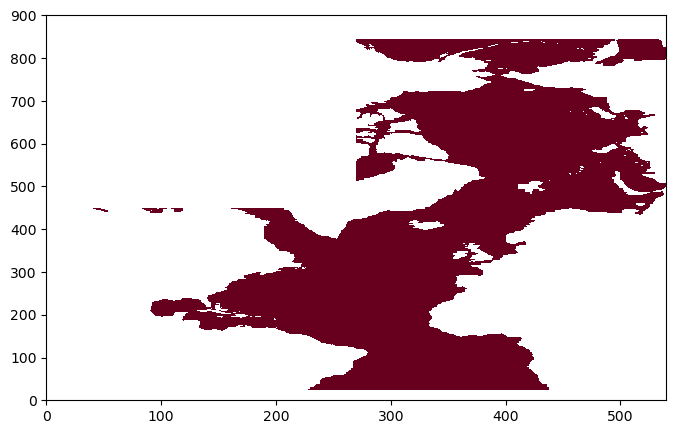

In [4]:
# calculate the sea ice edge for 1 and 2
thresh = .15  # 15% sea ice coverage as Barton

fig = plt.figure(figsize=(8,5))

# plot the basins, color by label
landmsk = np.zeros((ny,nx))
landmsk[np.isnan(hfC[0])] = 2
landmsk[hfC[0] == 1] = np.nan

# add the land
plt.pcolormesh(get_aste_tracer(hfC,nfx,nfy)[0],cmap='RdBu')

hfC[hfC<1] = np.nan

# example panel figure with the following:

- Panel A: Map of SST difference (2012–2017 mean − 2006–2010 mean)
- Panel B: Map of upper OHC difference for same periods
- Panel C: Time series of SST in Barents/Kara from 2006–2017
- Panel D: Linear trend map of SST (°C/year)

In [5]:
tstart = 3

### Panel A: SST trend compare 2012--17 with 2006--10

In [6]:
# create panel A with SST

# get the theta and salt for all years

all_SST = np.full((len(allyears[tstart:]),12,ny,nx),np.nan)
all_SSS = np.full((len(allyears[tstart:]),12,ny,nx),np.nan)


iy = 0
it = 0
for year in allyears[tstart:]:
    print(year)

    # get the datetime values
    # years = list(np.arange(2003,2018,1))  # 15 year period
    years = list(np.arange(year,year+1,1))
    years = [str(i) for i in years]
    years = np.array(years)
    # write the datetimes for the later period
    times = {}
    
    for year in years:
        times[year] = np.arange(1,13,1)   # write all the months for this example 5-year period
    
    tsstr,datetimes = get_tsteps(times,fnames,dt_aste,startyr,1,1)

    # get the theta/salt values
    thisyear_SST = np.full((len(tsstr),ny,nx),np.nan)  # one year length
    thisyear_SSS = np.full((len(tsstr),ny,nx),np.nan)  # one year length

    for i in range(len(tsstr)):
    
        # read the fldList
        file_name = 'state_3d_set1'
        meta_state_3d_set1 = parsemeta(dirState + file_name + "." + tsstr[i] + ".meta")
        fldlist = np.array(meta_state_3d_set1["fldList"])
        varnames = np.array(["THETA","SALT"])
        recs = np.array([])
        for var in varnames:
            irec = np.where(fldlist == var)
            recs = np.append(recs, irec[0][0])
        read = [int(tsstr[i])]
        
        # make sure order we write the variables is the same as the order in varnames, else we read the wrong thing
        THETAi,its,meta = rdmds(os.path.join(dirState, file_name),read,returnmeta=True,rec=recs[0])  # degC
        SALTi,its,meta = rdmds(os.path.join(dirState, file_name),read,returnmeta=True,rec=recs[1])  # degC
    
        thisyear_SST[i,:,:] = np.reshape(THETAi,(nz,ny,nx))[0] # just add SST
        thisyear_SSS[i,:,:] = np.reshape(SALTi,(nz,ny,nx))[0] # just add SST


    # get theta and salt alone so we can use for the freshwater content
    all_SST[iy,:,:,:] = thisyear_SST
    all_SSS[iy,:,:,:] = thisyear_SSS
    
    iy += 1

2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017


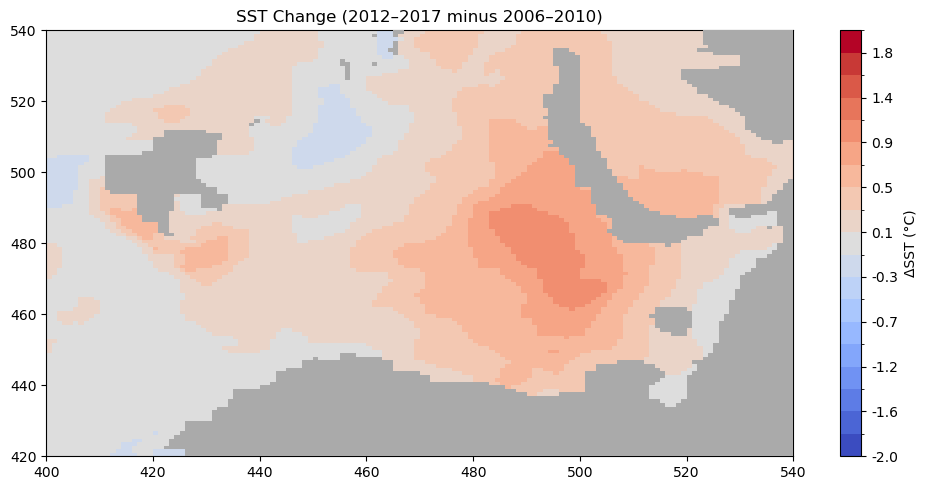

In [7]:
# Index ranges for early and late periods
early_years = np.arange(0, 5)    # 2006–2010 → indices 0–4
late_years = np.arange(6, 12)    # 2012–2017 → indices 6–11

# Compute mean SST over time and months
sst_early = np.mean(all_SST[early_years, :, :, :], axis=(0, 1))  # shape (ny, nx)
sst_late  = np.mean(all_SST[late_years, :, :, :], axis=(0, 1))   # shape (ny, nx)

# Difference map
sst_diff = get_aste_tracer(sst_late - sst_early, nfx, nfy)[0]  # shape (ny, nx)

# Create segmented colormap
bounds = np.linspace(-2, 2, 20)  # 8 segments: -2, -1.5, ..., 2
cmap = plt.get_cmap('coolwarm', len(bounds) - 1)
norm = BoundaryNorm(boundaries=bounds, ncolors=cmap.N)

# Plotting
plt.figure(figsize=(10, 5))
c = plt.pcolormesh(sst_diff, cmap=cmap, norm=norm, shading='auto')
plt.pcolormesh(get_aste_tracer(landmsk, nfx, nfy)[0], zorder=4, cmap="gray_r", vmin=1, vmax=4)

# Colorbar
cb = plt.colorbar(c, label='ΔSST (°C)', ticks=bounds[::2])
cb.ax.set_yticklabels([f'{b:.1f}' for b in bounds[::2]])

plt.title('SST Change (2012–2017 minus 2006–2010)')
# plt.xlabel('Longitude index')
# plt.ylabel('Latitude index')
plt.tight_layout()

plt.xlim(400, 540)
plt.ylim(420, 540)
plt.show()

In [8]:
# plot a side by side trend in SSS and SST per year

def get_slope(nyears,nmonths,value):
    '''
    inputs
        - nyears
        - nmonths
        - value: the attribute of shape years, months, ny, nx to be taken the slope of

    returns:
        - slope_value: the slope per year of that attribute as a map
    '''
    # # Subset years 2006–2016 (i.e., index 3:14)
    hc_sub = value[:, :, :, :]  # shape: (12, 12, ny, nx)
    
    # # Reshape to (time, ny, nx) for months since 2006 January, 2016 December
    hc_monthly = hc_sub.reshape(-1, ny, nx)  # shape: (144, ny, nx)
    
    # # Demean x for better numerical stability (optional)
    years = np.arange(nyears*nmonths) / nmonths + 2006  # shape: (132,)
    x = years - years.mean()
    X = np.broadcast_to(x[:, None, None], hc_monthly.shape)
    
    # # Compute means at each grid cell
    Y_hc = hc_monthly
    Y_hc_mean = np.nanmean(Y_hc, axis=0)
    
    # # subtract the mean at each grid point so data is zero-centered in time
    Y_hc_centered = Y_hc - Y_hc_mean
    
    # # Compute slope = cov(x, y) / var(x)
    slope_heat = np.nansum(X * Y_hc_centered, axis=0) / np.nansum(X**2, axis=0)

    return slope_heat

slope_SST = get_slope(12,12,all_SST) # degC/year
slope_SSS = get_slope(12,12,all_SSS) # PSU/year


In [20]:
# we should also load the mean sea ice edge so we can plot this on bathymetry with the gates
# do SIarea

# loop through the years to create the timeseries
alldatetimes = np.array([])
SIareas = np.zeros((len(allyears[tstart:]),ny,nx))

iy = 0
for year in allyears[tstart:]:
    print(year)

    # get the datetime values
    # years = list(np.arange(2003,2018,1))  # 15 year period
    years = list(np.arange(year,year+1,1))
    years = [str(i) for i in years]
    years = np.array(years)
    # write the datetimes for the later period
    times = {}
    
    for year in years:
        times[year] = np.arange(1,13,1)   # write all the months for this example 5-year period
    
    tsstr,datetimes = get_tsteps(times,fnames,dt_aste,startyr,1,1)

    ## 
    # get the SIarea values

    SIarea = np.full((len(tsstr),ny,nx),np.nan)  # 2D field 
  
    march_tsstr = tsstr[2]
    #print(march_tsstr)
    
    # read the fldList
    file_name = 'state_2d_set1'
    meta_state_2d_set1 = parsemeta(dirState + file_name + "." + march_tsstr + ".meta")
    fldlist = np.array(meta_state_2d_set1["fldList"])
    varnames = np.array(["SIarea"])
    recs = np.array([])
    for var in varnames:
        irec = np.where(fldlist == var)
        recs = np.append(recs, irec[0][0])

    
    
    # make sure order we write the variables is the same as the order in varnames, else we read the wrong thing
    # this is wrong, this is the fractional area -- to get the actual area we need to multiply by RAC
    sample_SI = np.zeros((3,ny,nx))
    for i in range(3):
        read = int(tsstr[i])
        SIareai,its,meta = rdmds(os.path.join(dirState, file_name),read,returnmeta=True,rec=recs[0])  # m^2/m^2
        SIarea = np.reshape(SIareai,(ny,nx))#*mymsk  # fraction of SIarea
        sample_SI[i] = SIarea
    
    SIareas[iy] = np.nanmean(sample_SI,axis=0)  # time-averaging

    iy += 1



2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017


In [10]:
mymsk = np.zeros((ny,nx))
idxs = np.where(mskBasin == 6)

for i,j in zip (idxs[0],idxs[1]):
    mymsk[i,j] = 1

# we have to add in until the edge of novaya zemlya
mymsk2 = get_aste_tracer(mymsk,nfx,nfy)[0]
mymsk2[:487,510:] = 1
mymsk2[:490,532:] = 1
mymsk = aste_tracer2compact(mymsk2,nfx,nfy)[0]

# remember to mask with land so we have the correct item
mymsk = mymsk * hfC[0]
mymsk[mymsk == 0] = np.nan

In [11]:
allyears[tstart:][6:8]

array([2012, 2013])

In [12]:
# get trace for sea ice
from scipy.ndimage import binary_dilation
from matplotlib.lines import Line2D

SI_early_tr = get_aste_tracer(np.nanmean(SIareas[:2], axis=0),nfx,nfy)[0]     # 2006–2008
# SI_mid_tr = get_aste_tracer(np.nanmean(SIareas[3:5], axis=0),nfx,nfy)[0]   # 2012-2013
SI_mid_tr = get_aste_tracer(np.nanmean(SIareas[6:8], axis=0),nfx,nfy)[0]   # 2012-2013
SI_late_tr = get_aste_tracer(np.nanmean(SIareas[-2:], axis=0),nfx,nfy)[0]      # 2015-2017

mymsk_tr = np.where(np.isnan(mymsk), 0, mymsk)

# Step 1: Get land mask on tracer grid
landmask_tr = get_aste_tracer(landmsk, nfx, nfy)[0] > 0  # Boolean mask where land is True

# Step 2: Expand land by 1 grid cell in all directions
landbuffer_tr = binary_dilation(landmask_tr, iterations=1)

SI_early_tr_masked = np.where(landbuffer_tr, np.nan, SI_early_tr)
SI_mid_tr_masked = np.where(landbuffer_tr, np.nan, SI_mid_tr)
SI_late_tr_masked  = np.where(landbuffer_tr, np.nan, SI_late_tr)

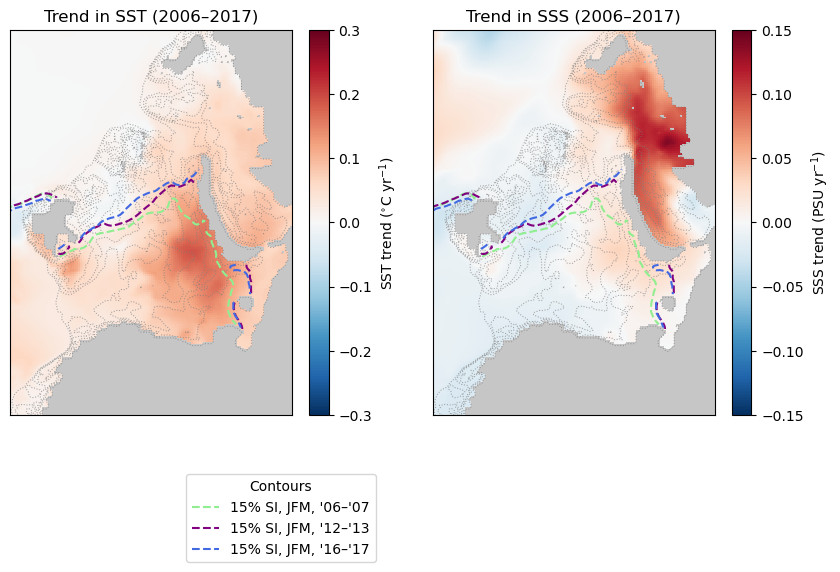

In [57]:
depth_tr = get_aste_tracer(mygrid['Depth'],nfx,nfy)[0]

depth_levels = [1,100,200,300,500]

# plot side by side of the two trends

fig = plt.figure(figsize = (10,5))

# first subplot -- SST trend
ax0 = plt.subplot(121)
cb = ax0.pcolormesh(get_aste_tracer(slope_SST,nfx,nfy)[0], cmap='RdBu_r',vmin=-.3,vmax=.3)
plt.colorbar(cb,label='SST trend ($^{\circ}$C yr$^{-1}$)')
ax0.pcolormesh(get_aste_tracer(landmsk,nfx,nfy)[0],cmap="Greys",zorder=2,vmin=0,vmax=6)
ax0.contour(depth_tr, levels=depth_levels, colors='gray', linewidths=0.75, linestyles=':',alpha=0.7)
ax0.set_title('Trend in SST (2006–2017)')
ax0.set_xlim(400,540)
ax0.set_ylim(400,600)

ax0.contour(SI_early_tr_masked, levels=[0.15], colors='lightgreen', linewidths=1.5, linestyles='--',label= "'06-'07 sea ice")
ax0.contour(SI_mid_tr_masked, levels=[0.15], colors='purple', linewidths=1.5, linestyles='--',label= "'12-'13 sea ice")
ax0.contour(SI_late_tr_masked,  levels=[0.15], colors='royalblue', linewidths=1.5, linestyles='--',label= "'16-'17 sea ice")
legend_elements = [
    Line2D([0], [0], color='lightgreen', linestyle='--', linewidth=1.5, label="15% SI, JFM, '06–'07"),
    Line2D([0], [0], color='purple', linestyle='--', linewidth=1.5, label="15% SI, JFM, '12–'13"),
    Line2D([0], [0], color='royalblue', linestyle='--', linewidth=1.5, label="15% SI, JFM, '16–'17"),
]

ax0.legend(handles=legend_elements,
           loc='lower left',
           bbox_to_anchor=(.6, -.4),
           fontsize=10,
           frameon=True,
           title='Contours')

ax0.set_xticks([])
ax0.set_yticks([])



# second subplot -- SSS trend
ax = plt.subplot(122)
cb = ax.pcolormesh(get_aste_tracer(slope_SSS,nfx,nfy)[0], cmap='RdBu_r',vmin=-.15,vmax=.15)
plt.colorbar(cb,label='SSS trend (PSU yr$^{-1}$)')
ax.pcolormesh(get_aste_tracer(landmsk,nfx,nfy)[0],cmap="Greys",zorder=2,vmin=0,vmax=6)
ax.contour(depth_tr, levels=depth_levels, colors='gray', linewidths=0.75, linestyles=':',alpha=0.7)
ax.set_title('Trend in SSS (2006–2017)')
ax.set_xlim(400,540)
ax.set_ylim(400,600)

ax.contour(SI_early_tr_masked, levels=[0.15], colors='lightgreen', linewidths=1.5, linestyles='--',label= "'06-'07 sea ice")
ax.contour(SI_mid_tr_masked, levels=[0.15], colors='purple', linewidths=1.5, linestyles='--',label= "'12-'13 sea ice")
ax.contour(SI_late_tr_masked,  levels=[0.15], colors='royalblue', linewidths=1.5, linestyles='--',label= "'16-'17 sea ice")

ax.set_xticks([])
ax.set_yticks([])

plt.savefig("/home/mmurakami/crios_backups/ASTE_270/Pemberton_BarentsSpaper/Masking_discussion_april2/story/SI_SStrends.png",dpi=300,bbox_inches='tight')

In [13]:
# do a side by side trend of SI totally timeseries and the SIC changes as a % per year

SIareastile = np.tile(SIareas[np.newaxis,:,:,:],(12,1,1,1))

slope_SI = get_slope(12,12,SIareastile)

In [14]:
SIareas.shape

(12, 1350, 270)

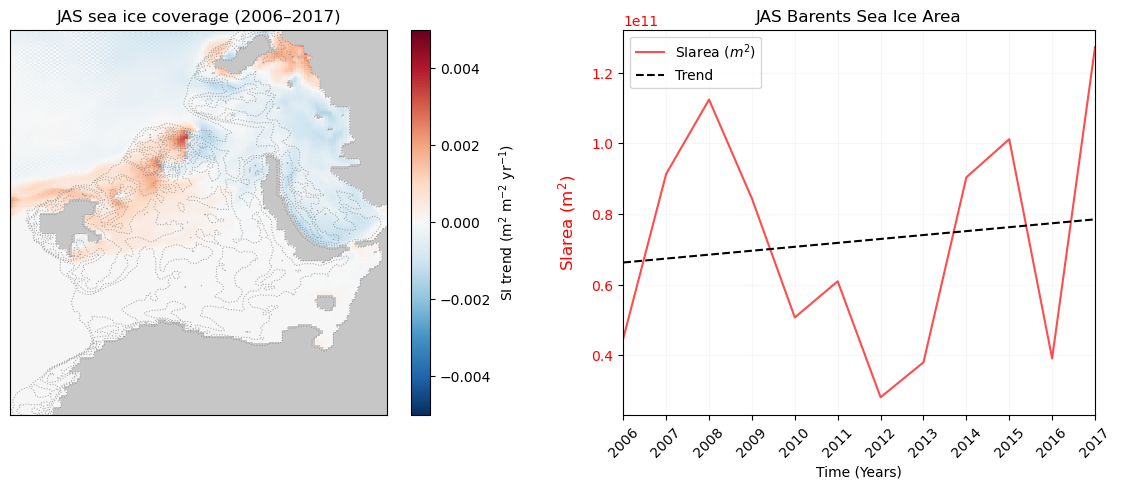

In [83]:
fig = plt.figure(figsize=(14, 5))

# First subplot
ax0 = plt.subplot(121)
cb = ax0.pcolormesh(get_aste_tracer(slope_SI, nfx, nfy)[0], cmap='RdBu_r', vmin=-.005, vmax=.005)
plt.colorbar(cb, label='SI trend (m$^{2}$ m$^{-2}$ yr$^{-1}$)')
ax0.pcolormesh(get_aste_tracer(landmsk, nfx, nfy)[0], cmap="Greys", zorder=2, vmin=0, vmax=6)
ax0.contour(depth_tr, levels=depth_levels, colors='gray', linewidths=0.75, linestyles=':', alpha=0.7)
ax0.set_title('JAS sea ice coverage (2006–2017)')
ax0.set_xlim(400, 540)
ax0.set_ylim(400, 600)
ax0.set_xticks([])
ax0.set_yticks([])

# Second subplot
ax1 = plt.subplot(122)
time = np.arange(0, 12, 1)
SIareasb = SIareas * np.tile(mymsk[np.newaxis, :, :], (12, 1, 1)) * np.tile(RAC[np.newaxis,:,:],(12,1,1))
JFM_SI = np.nansum(SIareasb, axis=(1, 2))
ax1.plot(time, JFM_SI, color="red", alpha=.7, label="SIarea ($m^{2}$)")
p = np.polyfit(time, JFM_SI, deg=1)
trend = np.polyval(p, time)
ax1.plot(time, trend, color="black", linestyle="--", label="Trend")
ax1.set_ylabel(r"SIarea (m$^{2}$)", color="red", fontsize=12, labelpad=10)
ax1.tick_params(axis='y', labelcolor="red")
ax1.set_xlabel("Time (Years)")
ax1.set_title("JAS Barents Sea Ice Area")
xtick_positions = np.arange(0, 12, 1)
xtick_labels = np.arange(2006, 2018)
ax1.set_xticks(xtick_positions)
ax1.set_xticklabels(xtick_labels, rotation=45)
ax1.set_xlim(0, 11)
ax1.grid(alpha=0.1)
ax1.legend(loc="upper left")

# Adjust horizontal space between subplots
plt.subplots_adjust(wspace=0.3)

plt.savefig("/home/mmurakami/crios_backups/ASTE_270/Pemberton_BarentsSpaper/Masking_discussion_april2/story/SI_trend_JAS.png",dpi=300,bbox_inches='tight')

plt.show()


### Panel B: map of the upper ocn OHC differences for the two periods

In [15]:
# np.cumsum(mygrid['DRF'][0:10])
heat_content = np.full((len(allyears[tstart:]),12,ny,nx),np.nan)

In [16]:
# get the 
# loop through the years to create the timeseries
# alldatetimes = np.array([])
# FW_times = np.array([])
# Heat_times = np.array([])  # this does not make sense as variable name
dstart = 0
dterm = 10  # upper 100 m

# from Lind Paper
sref = 35
tref = 0

iy = 0
for year in allyears[tstart:]:
    print(year)

    # get the datetime values
    # years = list(np.arange(2003,2018,1))  # 15 year period
    years = list(np.arange(year,year+1,1))
    years = [str(i) for i in years]
    years = np.array(years)
    # write the datetimes for the later period
    times = {}
    
    for year in years:
        times[year] = np.arange(1,13,1)   # write all the months for this example 5-year period
    
    tsstr,datetimes = get_tsteps(times,fnames,dt_aste,startyr,1,1)

    # get the theta/salt values
    # we also want salt to do the FW content
    # we want temperature and salt
    THETA = np.full((len(tsstr),nz,ny,nx),np.nan)
    
    for i in range(len(tsstr)):
    
        # read the fldList
        file_name = 'state_3d_set1'
        meta_state_3d_set1 = parsemeta(dirState + file_name + "." + tsstr[i] + ".meta")
        fldlist = np.array(meta_state_3d_set1["fldList"])
        varnames = np.array(["THETA","SALT"])
        recs = np.array([])
        for var in varnames:
            irec = np.where(fldlist == var)
            recs = np.append(recs, irec[0][0])
            
        read = [int(tsstr[i])]
        
        # make sure order we write the variables is the same as the order in varnames, else we read the wrong thing
        THETAi,its,meta = rdmds(os.path.join(dirState, file_name),read,returnmeta=True,rec=recs[0])  # degC.m
    
        THETA[i,:,:,:] = np.reshape(THETAi,(nz,ny,nx)) / hfC   # degC

    ##########################################################################################
    # get the heat content
    for i in range(len(datetimes)):
        # for calculating heat content:
            # weighted theta * rcp = J/m^2 which is the depth-weighted heat content of a cell
            # integrate over all values within the depth interval of choice
        
        thisTHETA = THETA[i] #* mymsk[np.newaxis,:,:]    # degC
        thisheat = (thisTHETA - tref) * myparms['rcp']   # degC * J/m^3.degC = J/m^3
        thisheat = thisheat * DRF3d  # J/m³ * m = J/m²

        # select heat based on the AW layer
        thisheat = thisheat[dstart:dterm]   # upper mygrid['DRF'][:dterm] m
        heat_content_2D = np.nansum(thisheat,axis=0)         # vertical integration (J/m^2)
        
        heat_content[iy,i,:,:] = heat_content_2D * 1e-6  # MJ/m^2

    #print()
    iy += 1

2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017


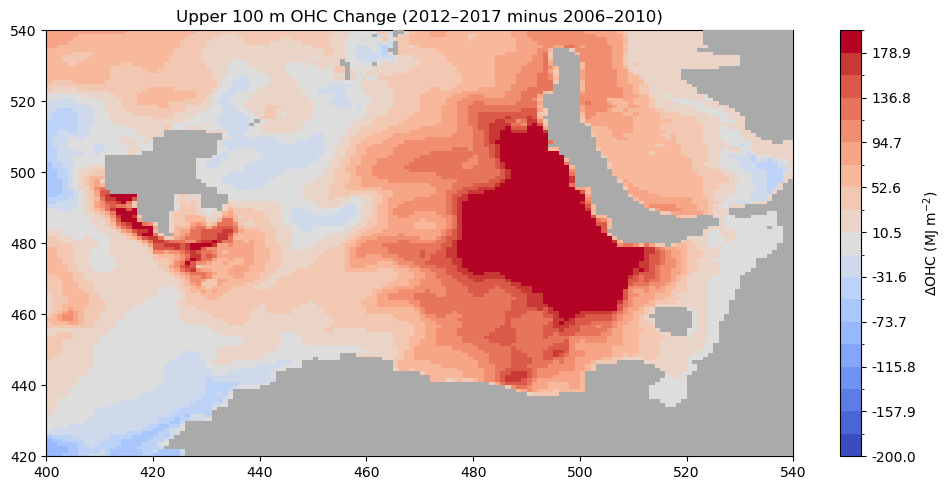

In [17]:
# Index ranges for early and late periods
early_years = np.arange(0, 5)    # 2006–2010 → indices 0–4
late_years = np.arange(6, 12)    # 2012–2017 → indices 6–11

# Compute mean SST over time and months
heat_content_early = np.mean(heat_content[early_years, :, :, :], axis=(0, 1))  # shape (ny, nx)
heat_content_late  = np.mean(heat_content[late_years, :, :, :], axis=(0, 1))   # shape (ny, nx)

# Difference map
ohc_diff = get_aste_tracer(heat_content_late - heat_content_early, nfx, nfy)[0]  # shape (ny, nx)

# Create segmented colormap
bounds = np.linspace(-200, 200, 20)  # 8 segments: -2, -1.5, ..., 2
cmap = plt.get_cmap('coolwarm', len(bounds) - 1)
norm = BoundaryNorm(boundaries=bounds, ncolors=cmap.N)

# Plotting
plt.figure(figsize=(10, 5))
c = plt.pcolormesh(ohc_diff, cmap=cmap, norm=norm, shading='auto')
plt.pcolormesh(get_aste_tracer(landmsk, nfx, nfy)[0], zorder=4, cmap="gray_r", vmin=1, vmax=4)

# Colorbar
cb = plt.colorbar(c, label='ΔOHC (MJ m$^{-2}$)', ticks=bounds[::2])
cb.ax.set_yticklabels([f'{b:.1f}' for b in bounds[::2]])

plt.title('Upper 100 m OHC Change (2012–2017 minus 2006–2010)')
# plt.xlabel('Longitude index')
# plt.ylabel('Latitude index')
plt.tight_layout()

plt.xlim(400, 540)
plt.ylim(420, 540)
plt.show()

### Plot C: timeseries of sea ice extent

In [18]:
# mymsk = (mskBasin == 6).astype(int)
# mymsk

In [107]:
# do SIarea

# loop through the years to create the timeseries
alldatetimes = np.array([])
SIareas = np.zeros((len(allyears[tstart:]),ny,nx))

iy = 0
for year in allyears[tstart:]:
    print(year)

    # get the datetime values
    # years = list(np.arange(2003,2018,1))  # 15 year period
    years = list(np.arange(year,year+1,1))
    years = [str(i) for i in years]
    years = np.array(years)
    # write the datetimes for the later period
    times = {}
    
    for year in years:
        times[year] = np.arange(1,13,1)   # write all the months for this example 5-year period
    
    tsstr,datetimes = get_tsteps(times,fnames,dt_aste,startyr,1,1)

    ## 
    # get the SIarea values

    SIarea = np.full((len(tsstr),ny,nx),np.nan)  # 2D field 
  
    march_tsstr = tsstr[2]
    
    # read the fldList
    file_name = 'state_2d_set1'
    meta_state_2d_set1 = parsemeta(dirState + file_name + "." + march_tsstr + ".meta")
    fldlist = np.array(meta_state_2d_set1["fldList"])
    varnames = np.array(["SIarea"])
    recs = np.array([])
    for var in varnames:
        irec = np.where(fldlist == var)
        recs = np.append(recs, irec[0][0])
        
    read = [int(tsstr[i])]
    
    # make sure order we write the variables is the same as the order in varnames, else we read the wrong thing
    # this is wrong, this is the fractional area -- to get the actual area we need to multiply by RAC
    SIareai,its,meta = rdmds(os.path.join(dirState, file_name),read,returnmeta=True,rec=recs[0])  # m^2/m^2
    SIarea = np.reshape(SIareai,(ny,nx))#*mymsk  # fraction of SIarea
    
    SIareas[iy] = SIarea

    iy += 1

2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017


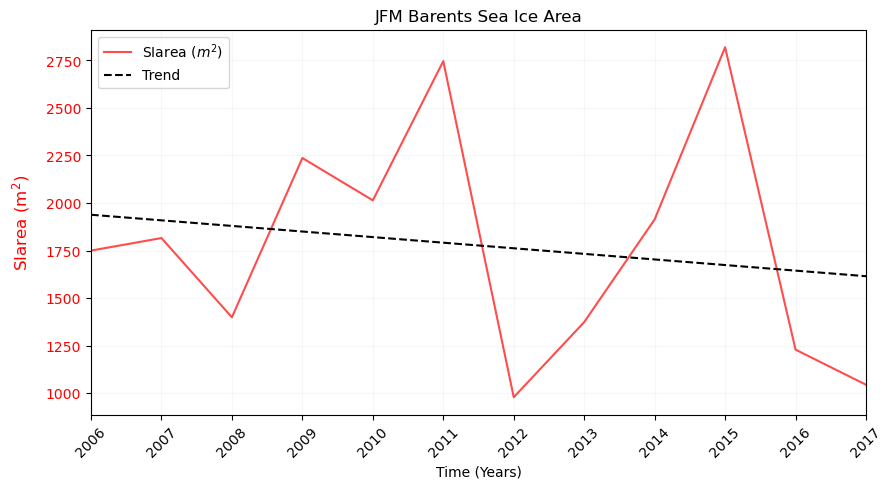

In [21]:
# remove the freshwater content and just add the heat content


# Define rolling window size (12 months for seasonal smoothing)
# window_size = 12

# Apply rolling mean
# heat_smoothed = pd.Series(heat_content_time.flatten()).rolling(window=window_size, center=True, min_periods=1).mean()

# Create figure and axis
fig = plt.figure(figsize=(10,5))

ax1 = plt.subplot(111)

# Time axis
time = np.arange(0, 12, 1)

# Plot smoothed heat content on primary y-axis (left)
SIareasb = SIareas * np.tile(mymsk[np.newaxis,:,:],(12,1,1))
march_SI = np.nansum(SIareasb,axis=(1,2))

ax1.plot(time, march_SI, color="red", alpha=.7, label="SIarea ($m^{2}$)")
# Fit a 1st degree polynomial (linear trend)
p = np.polyfit(time, march_SI, deg=1)
trend = np.polyval(p, time)

# Plot the trendline
ax1.plot(time, trend, color="black", linestyle="--", label="Trend")

ax1.set_ylabel(r"SIarea (m$^{2}$)", color="red", fontsize=12, labelpad=10)
ax1.tick_params(axis='y', labelcolor="red")

# X-axis labels and title
ax1.set_xlabel("Time (Years)")
ax1.set_title("JFM Barents Sea Ice Area")

# X-axis ticks
xtick_positions = np.arange(0, 12, 1)  # Every 12 months
xtick_labels = np.arange(2006, 2018)  # Years from 2004 to 2023
ax1.set_xticks(xtick_positions)
ax1.set_xticklabels(xtick_labels, rotation=45)  # Rotate for readability
ax1.set_xlim(0, 11)
ax1.grid(alpha=0.1)

# Legends
ax1.legend(loc="upper left")

# ax1.set_ylim(-300,300)
ax1.set_xlim(0,time[-1])

plt.show()

### plot D: trend in surface SST

In [31]:
# mymsk = (mskBasin == 6)

In [38]:
SIareas.shape

(12, 1350, 270)

In [25]:
# get trace for sea ice
from scipy.ndimage import binary_dilation
from matplotlib.lines import Line2D

SI_early_tr = get_aste_tracer(np.nanmean(SIareas[:2], axis=0),nfx,nfy)[0]     # 2006–2008
# SI_mid_tr = get_aste_tracer(np.nanmean(SIareas[3:5], axis=0),nfx,nfy)[0]   # 2012-2013
SI_mid_tr = get_aste_tracer(np.nanmean(SIareas[6:8], axis=0),nfx,nfy)[0]   # 2012-2013
SI_late_tr = get_aste_tracer(np.nanmean(SIareas[-2:], axis=0),nfx,nfy)[0]      # 2015-2017

mymsk_tr = np.where(np.isnan(mymsk), 0, mymsk)

# Step 1: Get land mask on tracer grid
landmask_tr = get_aste_tracer(landmsk, nfx, nfy)[0] > 0  # Boolean mask where land is True

# Step 2: Expand land by 1 grid cell in all directions
landbuffer_tr = binary_dilation(landmask_tr, iterations=1)

SI_early_tr_masked = np.where(landbuffer_tr, np.nan, SI_early_tr)
SI_mid_tr_masked = np.where(landbuffer_tr, np.nan, SI_mid_tr)
SI_late_tr_masked  = np.where(landbuffer_tr, np.nan, SI_late_tr)

In [26]:
# Subset years 2006–2016 (i.e., index 3:14)
hc_sub = heat_content[:, :, :, :]  # shape: (12, 12, ny, nx)

# Reshape to (time, ny, nx) for months since 2006 January, 2016 December
hc_monthly = hc_sub.reshape(-1, ny, nx)  # shape: (144, ny, nx)

# Demean x for better numerical stability (optional)
years = np.arange(12*12) / 12 + 2006  # shape: (132,)
x = years - years.mean()
X = np.broadcast_to(x[:, None, None], hc_monthly.shape)

# Compute means at each grid cell
Y_hc = hc_monthly
Y_hc_mean = np.nanmean(Y_hc, axis=0)

# subtract the mean at each grid point so data is zero-centered in time
Y_hc_centered = Y_hc - Y_hc_mean

# Compute slope = cov(x, y) / var(x)
slope_heat = np.nansum(X * Y_hc_centered, axis=0) / np.nansum(X**2, axis=0)

In [27]:
depth_tr = get_aste_tracer(mygrid['Depth'],nfx,nfy)[0]

depth_levels = [1,100,200,300,500]

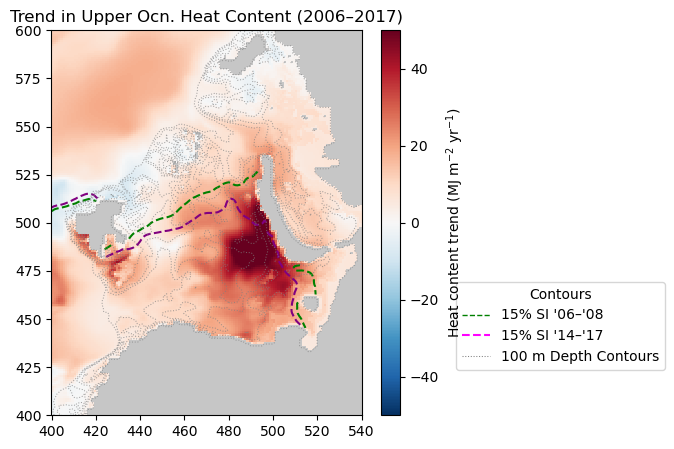

In [28]:
plt.figure(figsize=(5, 5))

ax = plt.subplot(111)
cb = ax.pcolormesh(get_aste_tracer(slope_heat,nfx,nfy)[0], cmap='RdBu_r',vmin=-50,vmax=50)
plt.colorbar(cb,label='Heat content trend (MJ m$^{-2}$ yr$^{-1}$)')
ax.pcolormesh(get_aste_tracer(landmsk,nfx,nfy)[0],cmap="Greys",zorder=2,vmin=0,vmax=6)
# Add contours at SI = 0.15
ax.contour(SI_early_tr_masked, levels=[0.15], colors='purple', linewidths=1.5, linestyles='--')
# ax.contour(SI_mid_tr_masked,  levels=[0.15], colors='blue', linewidths=1.5, linestyles='--')
ax.contour(SI_late_tr_masked,  levels=[0.15], colors='green', linewidths=1.5, linestyles='--')
ax.contour(depth_tr, levels=depth_levels, colors='gray', linewidths=0.75, linestyles=':',alpha=0.7)
ax.set_title('Trend in Upper Ocn. Heat Content (2006–2017)')
ax.set_xlim(400,540)
ax.set_ylim(400,600)

legend_elements = [
    Line2D([0], [0], color='green', linestyle='--', linewidth=1, label="15% SI '06–'08"),
    Line2D([0], [0], color='magenta', linestyle='--', linewidth=1.5, label="15% SI '14–'17"),
    Line2D([0], [0], color='gray', linestyle=':', linewidth=0.75, label='100 m Depth Contours'),
]

# Place legend to the right and downward (adjust anchor as needed)
plt.legend(handles=legend_elements,
           loc='lower right',
           bbox_to_anchor=(2, 0.1),
           fontsize=10,
           frameon=True,
           title='Contours')

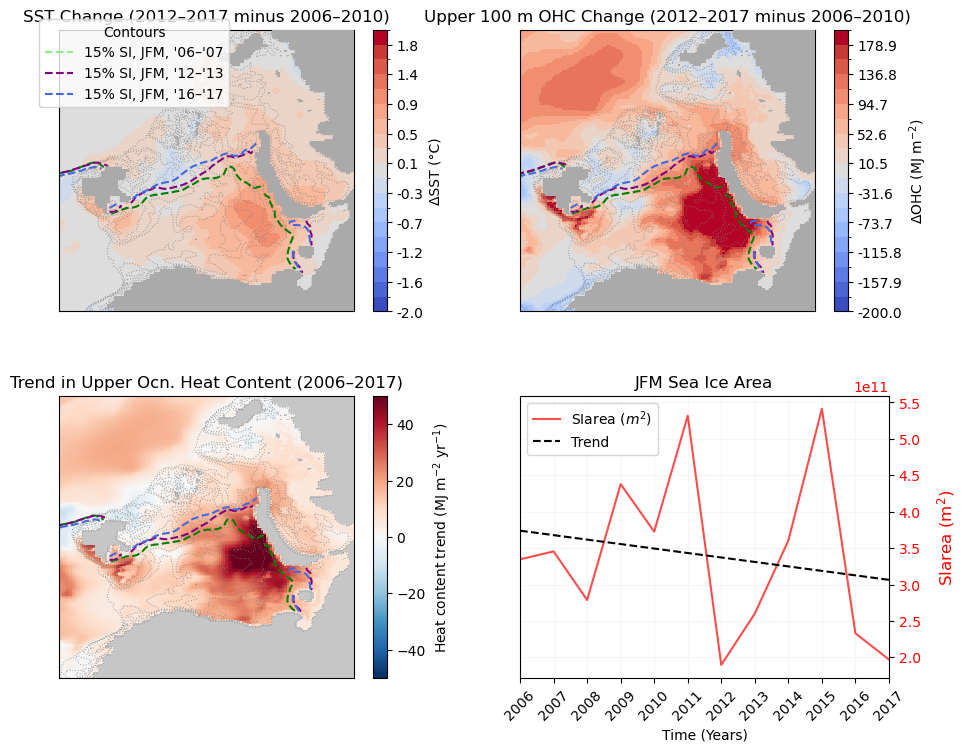

In [32]:
# make a 2 by 2 figure with the ones from above
early_years = np.arange(0, 5)    # 2006–2010 → indices 0–4
late_years = np.arange(6, 12)    # 2012–2017 → indices 6–11

fig = plt.figure(figsize = (10,8))

# first subplot - SST change
ax = plt.subplot(221)
sst_early = np.mean(all_SST[early_years, :, :, :], axis=(0, 1))  # shape (ny, nx)
sst_late  = np.mean(all_SST[late_years, :, :, :], axis=(0, 1))   # shape (ny, nx)
sst_diff = get_aste_tracer(sst_late - sst_early, nfx, nfy)[0]  # shape (ny, nx)
bounds = np.linspace(-2, 2, 20)  # 8 segments: -2, -1.5, ..., 2
cmap = plt.get_cmap('coolwarm', len(bounds) - 1)
norm = BoundaryNorm(boundaries=bounds, ncolors=cmap.N)
c = ax.pcolormesh(sst_diff, cmap=cmap, norm=norm, shading='auto')
ax.pcolormesh(get_aste_tracer(landmsk, nfx, nfy)[0], zorder=4, cmap="gray_r", vmin=1, vmax=4)
ax.contour(SI_early_tr_masked, levels=[0.15], colors='green', linewidths=1.5, linestyles='--')
ax.contour(SI_mid_tr_masked,  levels=[0.15], colors='purple', linewidths=1.5, linestyles='--')
ax.contour(SI_late_tr_masked,  levels=[0.15], colors='royalblue', linewidths=1.5, linestyles='--')
ax.contour(depth_tr, levels=depth_levels, colors='gray', linewidths=0.75, linestyles=':',alpha=0.7)
cb = plt.colorbar(c, label='ΔSST (°C)', ticks=bounds[::2])
cb.ax.set_yticklabels([f'{b:.1f}' for b in bounds[::2]])
ax.set_title('SST Change (2012–2017 minus 2006–2010)')
ax.set_xlim(400, 540)
ax.set_ylim(420, 600)
ax.set_xticks([])
ax.set_yticks([])


legend_elements = [
    Line2D([0], [0], color='lightgreen', linestyle='--', linewidth=1.5, label="15% SI, JFM, '06–'07"),
    Line2D([0], [0], color='purple', linestyle='--', linewidth=1.5, label="15% SI, JFM, '12–'13"),
    Line2D([0], [0], color='royalblue', linestyle='--', linewidth=1.5, label="15% SI, JFM, '16–'17"),
]


plt.legend(handles=legend_elements,
           loc='lower right',
           bbox_to_anchor=(.6, 0.7),
           fontsize=10,
           frameon=True,
           title='Contours')


# second subplot - upper ocean OHC change
ax = plt.subplot(222)
heat_content_early = np.mean(heat_content[early_years, :, :, :], axis=(0, 1))  # shape (ny, nx)
heat_content_late  = np.mean(heat_content[late_years, :, :, :], axis=(0, 1))   # shape (ny, nx)
ohc_diff = get_aste_tracer(heat_content_late - heat_content_early, nfx, nfy)[0]  # shape (ny, nx)
bounds = np.linspace(-200, 200, 20)  # 8 segments: -2, -1.5, ..., 2
cmap = plt.get_cmap('coolwarm', len(bounds) - 1)
norm = BoundaryNorm(boundaries=bounds, ncolors=cmap.N)
c = ax.pcolormesh(ohc_diff, cmap=cmap, norm=norm, shading='auto')
ax.pcolormesh(get_aste_tracer(landmsk, nfx, nfy)[0], zorder=4, cmap="gray_r", vmin=1, vmax=4)
ax.contour(SI_early_tr_masked, levels=[0.15], colors='green', linewidths=1.5, linestyles='--')
ax.contour(SI_mid_tr_masked,  levels=[0.15], colors='purple', linewidths=1.5, linestyles='--')
ax.contour(SI_late_tr_masked,  levels=[0.15], colors='royalblue', linewidths=1.5, linestyles='--')
ax.contour(depth_tr, levels=depth_levels, colors='gray', linewidths=0.75, linestyles=':',alpha=0.7)
cb = plt.colorbar(c, label='ΔOHC (MJ m$^{-2}$)', ticks=bounds[::2])
cb.ax.set_yticklabels([f'{b:.1f}' for b in bounds[::2]])
plt.title('Upper 100 m OHC Change (2012–2017 minus 2006–2010)')
plt.tight_layout()
plt.xlim(400, 540)
plt.ylim(420, 600)
ax.set_xticks([])
ax.set_yticks([])

# third subplot - trend in upper ocean heat content per year
ax = plt.subplot(223)
cb = ax.pcolormesh(get_aste_tracer(slope_heat,nfx,nfy)[0], cmap='RdBu_r',vmin=-50,vmax=50)
plt.colorbar(cb,label='Heat content trend (MJ m$^{-2}$ yr$^{-1}$)')
ax.pcolormesh(get_aste_tracer(landmsk,nfx,nfy)[0],cmap="Greys",zorder=2,vmin=0,vmax=6)
# Add contours at SI = 0.15
ax.contour(SI_early_tr_masked, levels=[0.15], colors='green', linewidths=1.5, linestyles='--')
ax.contour(SI_mid_tr_masked,  levels=[0.15], colors='purple', linewidths=1.5, linestyles='--')
ax.contour(SI_late_tr_masked,  levels=[0.15], colors='royalblue', linewidths=1.5, linestyles='--')
ax.contour(depth_tr, levels=depth_levels, colors='gray', linewidths=0.75, linestyles=':',alpha=0.7)
# ax.legend(loc="upper left")
ax.set_title('Trend in Upper Ocn. Heat Content (2006–2017)')
ax.set_xlim(400,540)
ax.set_ylim(400,600)
ax.set_xticks([])
ax.set_yticks([])



# fourth subplot - march sea ice extent

# remove the freshwater content and just add the heat content


# Define rolling window size (12 months for seasonal smoothing)
# window_size = 12

# Apply rolling mean
# heat_smoothed = pd.Series(heat_content_time.flatten()).rolling(window=window_size, center=True, min_periods=1).mean()

# Create figure and axis
ax1 = plt.subplot(224)
time = np.arange(0, 12, 1)
SIareasb = SIareas * np.tile(mymsk[np.newaxis,:,:],(12,1,1)) * np.tile(RAC[np.newaxis,:,:],(12,1,1))
march_SI = np.nansum(SIareasb,axis=(1,2))
ax1.plot(time, march_SI, color="red", alpha=.7, label="SIarea ($m^{2}$)")
p = np.polyfit(time, march_SI, deg=1)
trend = np.polyval(p, time)
ax1.plot(time, trend, color="black", linestyle="--", label="Trend")
# Y-axis on the right
ax1.yaxis.tick_right()
ax1.yaxis.set_label_position("right")
ax1.set_ylabel(r"SIarea (m$^{2}$)", color="red", fontsize=12, labelpad=10)
ax1.tick_params(axis='y', labelcolor="red")

# X-axis settings
ax1.set_xlabel("Time (Years)")
ax1.set_title("JFM Sea Ice Area")
xtick_positions = np.arange(0, 12, 1)
xtick_labels = np.arange(2006, 2018)
ax1.set_xticks(xtick_positions)
ax1.set_xticklabels(xtick_labels, rotation=45)
ax1.set_xlim(0, time[-1])
ax1.grid(alpha=0.1)
ax1.legend(loc="upper left")
ax1.set_xlim(0,time[-1])
fig.subplots_adjust(
    top=0.93,    # leave space for suptitle if needed
    bottom=0.12, # more space at the bottom
    left=0.07,
    right=0.90,  # more space on the right
    wspace=0.25,
    hspace=0.3
)

plt.savefig("heat_seaice.png",dpi=300)

# 2x2 - three time periods for the depth of the AW layer as a map for four x 3-year periods

In [86]:
# we need to initialize the temperature and find the depth of the AW layer from RAC
AW_thickness = np.full((len(allyears[tstart:]), 12, ny, nx), np.nan)
AW_presence  = np.full((len(allyears[tstart:]), 12, ny, nx), np.nan)  # if you want just presence/absence
aw_top_depth = np.full((len(allyears), 12, ny, nx), np.nan)

In [124]:
dstart = 0
dterm = 10  # upper 100 m

# from Lind Paper
sref = 35
tref = 0

# Initialize index
iy = 0

for year in allyears[tstart:]:
    print(year)

    # Set up year/month dictionaries
    years = [str(year)]
    times = {year: np.arange(1, 13, 1)}  # all months

    # Get time steps and datetime array
    tsstr, datetimes = get_tsteps(times, fnames, dt_aste, startyr, 1, 1)

    # Preallocate arrays for this year
    THETA = np.full((len(tsstr), nz, ny, nx), np.nan)

    # Load THETA
    for i in range(len(tsstr)):
        file_name = 'state_3d_set1'
        meta_state_3d_set1 = parsemeta(dirState + file_name + "." + tsstr[i] + ".meta")
        fldlist = np.array(meta_state_3d_set1["fldList"])
        varnames = np.array(["THETA", "SALT"])
        recs = np.array([np.where(fldlist == var)[0][0] for var in varnames])

        read = [int(tsstr[i])]
        THETAi, its, meta = rdmds(os.path.join(dirState, file_name), read, returnmeta=True, rec=recs[0])
        THETA[i, :, :, :] = np.reshape(THETAi, (nz, ny, nx)) / hfC  # degC

    # Loop through months in this year
    for i in range(len(datetimes)):
        myi = i
        thisTHETA = THETA[i]  # shape (nz, ny, nx)

        # --- HEAT CONTENT ---
        thisheat = (thisTHETA - tref) * myparms['rcp']   # J/m^3
        thisheat = thisheat * DRF3d                      # J/m^2
        thisheat = thisheat[dstart:dterm]
        heat_content_2D = np.nansum(thisheat, axis=0)    # MJ/m^2
        heat_content[iy, i, :, :] = heat_content_2D * 1e-6

        # --- AW MASK & THICKNESS ---
        aw_mask = (thisTHETA > 2.0).astype(int)  # T > 2°C → AW present
        aw_mask_z = aw_mask[dstart:dterm]        # optional: restrict to top 100m
        aw_thick_2D = np.sum(aw_mask_z * DRF3d[dstart:dterm], axis=0)  # m
        aw_pres_2D = np.any(aw_mask_z, axis=0).astype(int)

        AW_thickness[iy, i, :, :] = aw_thick_2D
        AW_presence[iy, i, :, :] = aw_pres_2D

        # AW top depth
        # Initialize array for top depth
        top_depth = np.full((ny, nx), np.nan)

        for j in range(ny):
            for i in range(nx):
                vertical_column = aw_mask[:, j, i]
                if np.any(vertical_column):
                    first_index = np.argmax(vertical_column)  # shallowest depth with AW
                    if top_depth[j, i] != 0:
                        top_depth[j, i] = np.sum(DRF3d[:first_index, j, i])  # surface to that level

        aw_top_depth[iy, myi] = top_depth

    iy += 1

2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017


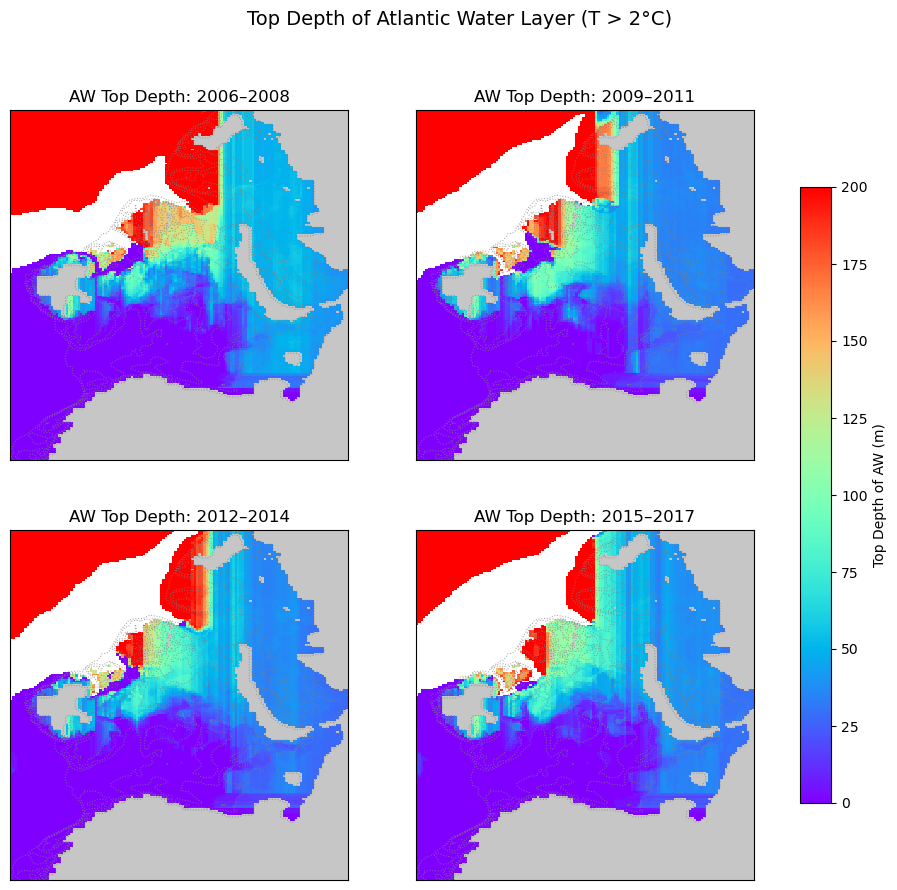

In [125]:
periods = [allyears[:3], allyears[3:6], allyears[6:9], allyears[9:]]
period_labels = ["2006–2008", "2009–2011", "2012–2014", "2015–2017"]
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
axs = axs.flatten()

for k, years in enumerate(periods):
    year_idxs = [np.where(allyears == y)[0][0] for y in years]

    # Extract and average over time
    top_depth_subset = aw_top_depth[year_idxs, :, :, :]  # (years, months, ny, nx)
    top_depth_avg = np.nanmean(top_depth_subset, axis=(0, 1))  # (ny, nx)

    # Plot
    ax = axs[k]
    im = ax.pcolormesh(get_aste_tracer(top_depth_avg,nfx,nfy)[0], cmap='rainbow', vmin=0, vmax=200, shading='auto')
    ax.set_title(f'AW Top Depth: {period_labels[k]}')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlim(400,540)
    ax.set_ylim(400,600)
    ax.pcolormesh(get_aste_tracer(landmsk,nfx,nfy)[0],cmap="Greys",zorder=2,vmin=0,vmax=6)
    ax.contour(depth_tr, levels=depth_levels, colors='gray', linewidths=0.75, linestyles=':',alpha=0.7)


# Colorbar
cbar = fig.colorbar(im, ax=axs, shrink=0.8, label='Top Depth of AW (m)')
plt.suptitle('Top Depth of Atlantic Water Layer (T > 2°C)', fontsize=14)
plt.tight_layout(rect=[1, 0, 1, 0.95])
plt.show()

In [112]:
# do a scatter plot of presence vs thickness
avg_presence = np.nanmean(AW_presence[years, :, mymsk], axis=(0, 1)).flatten()
avg_thickness = np.nanmean(AW_thickness[years, :, mymsk], axis=(0, 1)).flatten()

plt.scatter(avg_presence, avg_thickness, alpha=0.5)
plt.xlabel("AW Presence Fraction")
plt.ylabel("AW Layer Thickness (m)")

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [116]:
presence_smoothed.shape

(12,)

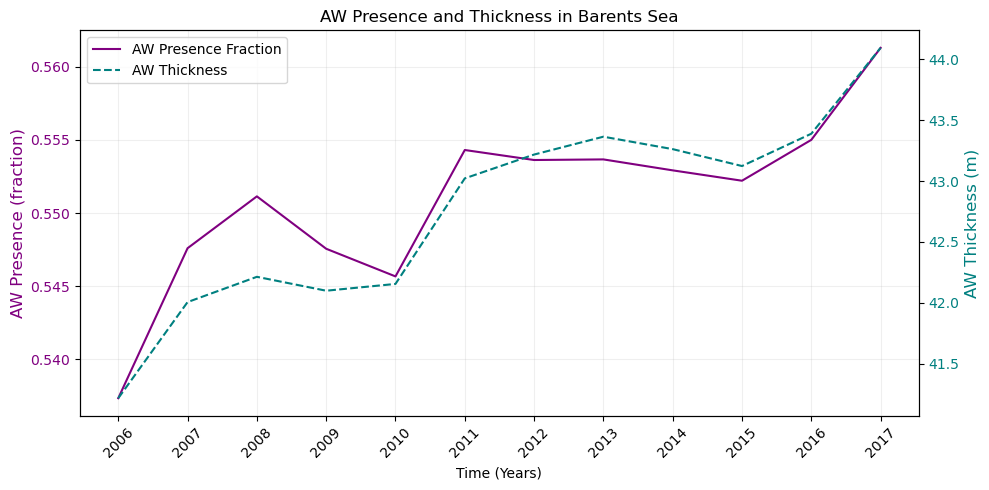

In [119]:
# Averages already calculated over Barents or region of interest
presence_area = np.nanmean(AW_presence[:, :, mymsk], axis=(1, 2))  # shape (years, months)
thickness_vol = np.nanmean(AW_thickness[:, :, mymsk], axis=(1, 2))  # shape (years, months)

# Flatten to time series (year * 12 months)
presence_flat = presence_area.flatten()
thickness_flat = thickness_vol.flatten()

# Time axis: monthly resolution for 12 years
time = np.arange(0, 12, 1)  # 2006–2017

# Apply 12-month rolling mean
window_size = 12
presence_smoothed = pd.Series(presence_flat).rolling(window=window_size, center=True, min_periods=1).mean()
thickness_smoothed = pd.Series(thickness_flat).rolling(window=window_size, center=True, min_periods=1).mean()

# Create figure and axis
fig = plt.figure(figsize=(10, 5))
ax1 = plt.subplot(111)

# --- Primary y-axis: AW Presence ---
ax1.plot(time, presence_smoothed, color="purple", label="AW Presence Fraction")
ax1.set_ylabel("AW Presence (fraction)", color="purple", fontsize=12)
ax1.tick_params(axis='y', labelcolor="purple")

# --- Secondary y-axis: AW Thickness ---
ax2 = ax1.twinx()
ax2.plot(time, thickness_smoothed, color="teal", label="AW Thickness", linestyle="--")
ax2.set_ylabel("AW Thickness (m)", color="teal", fontsize=12)
ax2.tick_params(axis='y', labelcolor="teal")

# --- X-axis settings ---
xtick_positions = np.arange(0, 12, 1)
xtick_labels = np.arange(2006, 2018)
ax1.set_xticks(xtick_positions)
ax1.set_xticklabels(xtick_labels, rotation=45)
ax1.set_xlabel("Time (Years)")

# Title and grid
ax1.set_title("AW Presence and Thickness in Barents Sea")
ax1.grid(alpha=0.2)

# Legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper left")

# Optional y-limits
# ax1.set_ylim(0, 1)
# ax2.set_ylim(0, 300)

plt.tight_layout()
plt.savefig("presence.png",dpi=300)
plt.show()


# make some trend plots of the actual terms in the budget

In [ ]:
# what are the terms in the heat budget

# for surface we have SFLUX and oceSPflx for salinity
# for surface we have TFLUX and oceQsw for heat
# let's do a 2x2 trend plot for these four from 2006--2017

# we have the get_slope term so we can use this to plot things

# load the terms - these are both 2d fields

In [86]:
# we should also load the mean sea ice edge so we can plot this on bathymetry with the gates
# do SIarea

# loop through the years to create the timeseries
alldatetimes = np.array([])
all_SFLUX = np.zeros((len(allyears[tstart:]),12,ny,nx))
all_oceSPflx = np.zeros((len(allyears[tstart:]),12,ny,nx))
all_TFLUX = np.zeros((len(allyears[tstart:]),12,ny,nx))
all_oceQsw = np.zeros((len(allyears[tstart:]),12,ny,nx))

iy = 0
for year in allyears[tstart:]:
    print(year)

    # get the datetime values
    # years = list(np.arange(2003,2018,1))  # 15 year period
    years = list(np.arange(year,year+1,1))
    years = [str(i) for i in years]
    years = np.array(years)
    # write the datetimes for the later period
    times = {}
    
    for year in years:
        times[year] = np.arange(1,13,1)   # write all the months for this example 5-year period
    
    tsstr,datetimes = get_tsteps(times,fnames,dt_aste,startyr,1,1)

    ## 
    # get the SIarea values

    SIarea = np.full((len(tsstr),ny,nx),np.nan)  # 2D field 
  
    march_tsstr = tsstr[2]
    
    # read the fldList
    file_name = 'budg2d_zflux_set1'
    meta_budg2d_zflux_set1 = parsemeta(dirIn + file_name + "." + march_tsstr + ".meta")
    fldlist = np.array(meta_budg2d_zflux_set1["fldList"])
    varnames = np.array(["TFLUX","oceQsw","oceSPflx","SFLUX"])
    recs = np.array([])
    for var in varnames:
        irec = np.where(fldlist == var)
        recs = np.append(recs, irec[0][0])

    # make sure order we write the variables is the same as the order in varnames, else we read the wrong thing
    # this is wrong, this is the fractional area -- to get the actual area we need to multiply by RAC
    for i in range(len(tsstr)):
        read = int(tsstr[i])
        TFLUXi,its,meta = rdmds(os.path.join(dirIn, file_name),read,returnmeta=True,rec=recs[0]) # W/m^2
        TFLUX = np.reshape(TFLUXi,(ny,nx))
        oceQswi,its,meta = rdmds(os.path.join(dirIn, file_name),read,returnmeta=True,rec=recs[1]) # W/m^2
        oceQsw = np.reshape(oceQswi,(ny,nx))
        oceSPflxi,its,meta = rdmds(os.path.join(dirIn, file_name),read,returnmeta=True,rec=recs[2]) # g/m^2/s
        oceSPflx = np.reshape(oceSPflxi,(ny,nx))
        SFLUXi,its,meta = rdmds(os.path.join(dirIn, file_name),read,returnmeta=True,rec=recs[3])  # g/m^2/s
        SFLUX = np.reshape(SFLUXi,(ny,nx))
    
        all_TFLUX[iy,i] = TFLUX
        all_SFLUX[iy,i] = SFLUX
        all_oceSPflx[iy,i] = oceSPflx
        all_oceQsw[iy,i] = oceQsw

    iy += 1

2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017


In [88]:
slope_TFLUX = get_slope(12,12,all_TFLUX)
slope_SFLUX = get_slope(12,12,all_SFLUX)
slope_oceSPflx = get_slope(12,12,all_oceSPflx)
slope_oceQsw = get_slope(12,12,all_oceQsw)

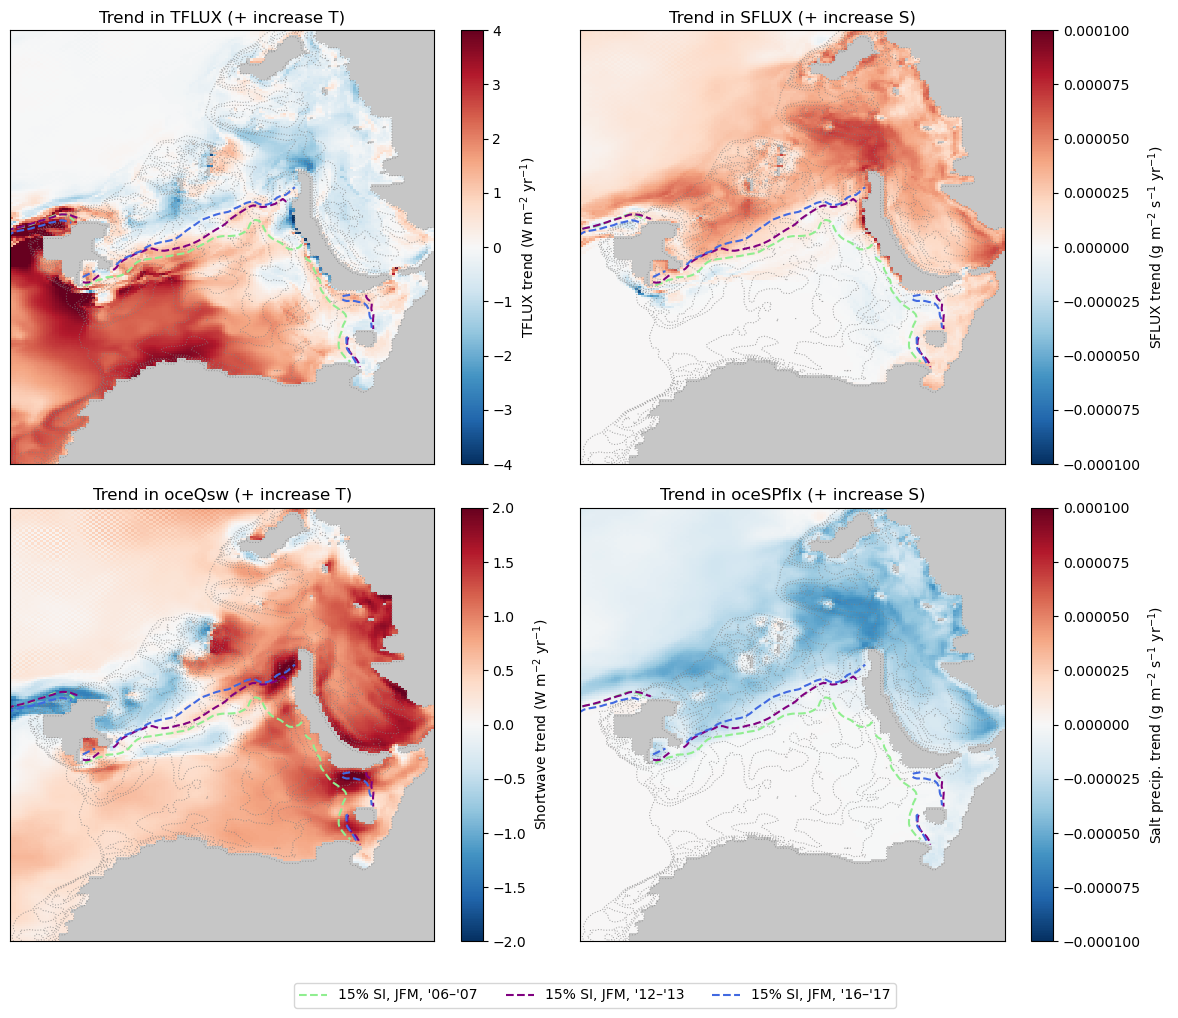

In [102]:
# make a figure of these
depth_tr = get_aste_tracer(mygrid['Depth'], nfx, nfy)[0]
depth_levels = [1, 100, 200, 300, 500]

fig = plt.figure(figsize=(12, 10))

data_list = [
    (slope_TFLUX, 'Trend in TFLUX (+ increase T)', 'TFLUX trend (W m$^{-2}$ yr$^{-1}$)', -4, 4),
    (slope_SFLUX, 'Trend in SFLUX (+ increase S)', 'SFLUX trend (g m$^{-2}$ s$^{-1}$ yr$^{-1}$)', -1e-4, 1e-4),
    (slope_oceQsw, 'Trend in oceQsw (+ increase T)', 'Shortwave trend (W m$^{-2}$ yr$^{-1}$)', -2, 2),
    (slope_oceSPflx, 'Trend in oceSPflx (+ increase S)', 'Salt precip. trend (g m$^{-2}$ s$^{-1}$ yr$^{-1}$)', -1e-4, 1e-4),
]

for i, (data, title, cbar_label, vmin, vmax) in enumerate(data_list):
    ax = plt.subplot(2, 2, i + 1)
    pc = ax.pcolormesh(get_aste_tracer(data, nfx, nfy)[0], cmap='RdBu_r', vmin=vmin, vmax=vmax)
    plt.colorbar(pc, ax=ax, label=cbar_label)
    ax.pcolormesh(get_aste_tracer(landmsk, nfx, nfy)[0], cmap="Greys", zorder=2, vmin=0, vmax=6)
    ax.contour(depth_tr, levels=depth_levels, colors='gray', linewidths=0.75, linestyles=':', alpha=0.7)
    ax.set_title(title)
    ax.set_xlim(400, 540)
    ax.set_ylim(400, 600)

    # Add sea ice trend contours
    ax.contour(SI_early_tr_masked, levels=[0.15], colors='lightgreen', linewidths=1.5, linestyles='--')
    ax.contour(SI_mid_tr_masked, levels=[0.15], colors='purple', linewidths=1.5, linestyles='--')
    ax.contour(SI_late_tr_masked, levels=[0.15], colors='royalblue', linewidths=1.5, linestyles='--')

    ax.set_xticks([])
    ax.set_yticks([])

# Add a shared legend below the plots
legend_elements = [
    Line2D([0], [0], color='lightgreen', linestyle='--', linewidth=1.5, label="15% SI, JFM, '06–'07"),
    Line2D([0], [0], color='purple', linestyle='--', linewidth=1.5, label="15% SI, JFM, '12–'13"),
    Line2D([0], [0], color='royalblue', linestyle='--', linewidth=1.5, label="15% SI, JFM, '16–'17"),
]
fig.legend(handles=legend_elements, loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.02), fontsize=10, frameon=True)

plt.tight_layout(rect=[0, 0.03, 1, 1])
plt.savefig("/home/mmurakami/crios_backups/ASTE_270/Pemberton_BarentsSpaper/Masking_discussion_april2/story/surface_fc_trends.png",dpi=300,bbox_inches='tight')
